In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations
from scipy.stats import pearsonr

# Negative Transfer
- Load results
- Plot heatmaps for pairwise accuracy
- Correlate pairwise accuracy matrices

In [25]:
p_mlp_single = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/condition/balanced/connectomes'
p_mlp_pairs = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/neg_transfer/mlp'

p_cnn_single = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/neg_transfer/cnn/single'
p_cnn_pairs = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/neg_transfer/cnn'

p_concat_single = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/neg_transfer/concat/single'
p_concat_pairs = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/neg_transfer/concat'

p_deeper_single = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/neg_transfer/deeper/single'
p_deeper_pairs = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/neg_transfer/deeper'

cases = ['SZ',
            'ASD',
            'BIP',
            'DEL22q11_2',
            'DUP22q11_2',
            'DEL16p11_2',
            'DUP16p11_2',
            'DEL1q21_1',
            'DUP1q21_1']

case_to_idx = dict(zip(cases,range(len(cases))))

pairs = [combo for combo in combinations(cases,2)]

# MLP
## Load Single Task Results

In [3]:
mlp_single = np.zeros(len(cases))
for case in cases:
    p = os.path.join(p_mlp_single,f'{case}')
    final_acc = []
    for i in range(5):
        p_fold = os.path.join(p,f'fold_{i}')
        file = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0]
        df = pd.read_csv(os.path.join(p,f'fold_{i}',file),index_col=0,header=[0,1])[case]
        final_acc.append(df['Accuracy/test'].iloc[-1])
    mlp_single[case_to_idx[case]] = np.mean(final_acc)

## Load Pair Results

In [26]:
mlp_pairs = np.zeros((len(cases),len(cases)))
for i in range(1,len(pairs)+1):
    p = os.path.join(p_mlp_pairs,f'pair_{i}')
    p_fold = os.path.join(p,'fold_0')
    case1 = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0].split('.')[0].split('-')[2]
    case2 = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0].split('.')[0].split('-')[3]
    final_acc_case1 = []
    final_acc_case2 = []
    for i in range(5):
        p_fold = os.path.join(p,f'fold_{i}')
        file = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0]
        df = pd.read_csv(os.path.join(p_fold,file),index_col=0,header=[0,1])
        final_acc_case1.append(df[case1]['Accuracy/test'].iloc[-1])
        final_acc_case2.append(df[case2]['Accuracy/test'].iloc[-1])
    
    # case1, case2: accuracy of case1 trained with case2
    mlp_pairs[case_to_idx[case1],case_to_idx[case2]] = np.mean(final_acc_case1)
    mlp_pairs[case_to_idx[case2],case_to_idx[case1]] = np.mean(final_acc_case2)

np.fill_diagonal(mlp_pairs,mlp_single)

# CNN
## Load Single Task Results

In [27]:
cnn_single = np.zeros(len(cases))
for case in cases:
    p = os.path.join(p_cnn_single,f'{case}')
    final_acc = []
    for i in range(5):
        p_fold = os.path.join(p,f'fold_{i}')
        file = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0]
        df = pd.read_csv(os.path.join(p,f'fold_{i}',file),index_col=0,header=[0,1])[case]
        final_acc.append(df['Accuracy/test'].iloc[-1])
    cnn_single[case_to_idx[case]] = np.mean(final_acc)

## Load Pair Results

In [28]:
cnn_pairs = np.zeros((len(cases),len(cases)))
for i in range(1,len(pairs)+1):
    p = os.path.join(p_cnn_pairs,f'pair_{i}')
    p_fold = os.path.join(p,'fold_0')
    case1 = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0].split('.')[0].split('-')[2]
    case2 = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0].split('.')[0].split('-')[3]
    final_acc_case1 = []
    final_acc_case2 = []
    for i in range(5):
        p_fold = os.path.join(p,f'fold_{i}')
        files = [f for f in os.listdir(p_fold) if f[-4:]=='.csv']
        file = files[0]
        df = pd.read_csv(os.path.join(p_fold,file),index_col=0,header=[0,1])
        final_acc_case1.append(df[case1]['Accuracy/test'].iloc[-1])
        final_acc_case2.append(df[case2]['Accuracy/test'].iloc[-1])
    
    # case1, case2: accuracy of case1 trained with case2
    cnn_pairs[case_to_idx[case1],case_to_idx[case2]] = np.mean(final_acc_case1)
    cnn_pairs[case_to_idx[case2],case_to_idx[case1]] = np.mean(final_acc_case2)

np.fill_diagonal(cnn_pairs,cnn_single)

# Concat
## Load Single Task Results

In [29]:
concat_single = np.zeros(len(cases))
for case in cases:
    p = os.path.join(p_concat_single,f'{case}')
    final_acc = []
    for i in range(5):
        p_fold = os.path.join(p,f'fold_{i}')
        file = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0]
        df = pd.read_csv(os.path.join(p,f'fold_{i}',file),index_col=0,header=[0,1])[case]
        final_acc.append(df['Accuracy/test'].iloc[-1])
    concat_single[case_to_idx[case]] = np.mean(final_acc)

## Load Pair Results

In [30]:
concat_pairs = np.zeros((len(cases),len(cases)))
for i in range(1,len(pairs)+1):
    p = os.path.join(p_concat_pairs,f'pair_{i}')
    p_fold = os.path.join(p,'fold_0')
    case1 = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0].split('.')[0].split('-')[2]
    case2 = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0].split('.')[0].split('-')[3]
    final_acc_case1 = []
    final_acc_case2 = []
    for i in range(5):
        p_fold = os.path.join(p,f'fold_{i}')
        files = [f for f in os.listdir(p_fold) if f[-4:]=='.csv']
        file = files[0]
        df = pd.read_csv(os.path.join(p_fold,file),index_col=0,header=[0,1])
        final_acc_case1.append(df[case1]['Accuracy/test'].iloc[-1])
        final_acc_case2.append(df[case2]['Accuracy/test'].iloc[-1])
    
    # case1, case2: accuracy of case1 trained with case2
    concat_pairs[case_to_idx[case1],case_to_idx[case2]] = np.mean(final_acc_case1)
    concat_pairs[case_to_idx[case2],case_to_idx[case1]] = np.mean(final_acc_case2)

np.fill_diagonal(concat_pairs,concat_single)

# Deeper
# Load Single Task Results

In [31]:
deeper_single = np.zeros(len(cases))
for case in cases:
    p = os.path.join(p_deeper_single,f'{case}')
    final_acc = []
    for i in range(5):
        p_fold = os.path.join(p,f'fold_{i}')
        file = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0]
        df = pd.read_csv(os.path.join(p,f'fold_{i}',file),index_col=0,header=[0,1])[case]
        final_acc.append(df['Accuracy/test'].iloc[-1])

    deeper_single[case_to_idx[case]] = np.mean(final_acc)

## Load Pair Results

In [32]:
deeper_pairs = np.zeros((len(cases),len(cases)))
for i in range(1,len(pairs)+1):
    p = os.path.join(p_deeper_pairs,f'pair_{i}')
    p_fold = os.path.join(p,'fold_0')
    case1 = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0].split('.')[0].split('-')[2]
    case2 = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0].split('.')[0].split('-')[3]
    final_acc_case1 = []
    final_acc_case2 = []
    for i in range(5):
        p_fold = os.path.join(p,f'fold_{i}')
        files = [f for f in os.listdir(p_fold) if f[-4:]=='.csv']
        file = files[0]
        df = pd.read_csv(os.path.join(p_fold,file),index_col=0,header=[0,1])
        final_acc_case1.append(df[case1]['Accuracy/test'].iloc[-1])
        final_acc_case2.append(df[case2]['Accuracy/test'].iloc[-1])
    
    # case1, case2: accuracy of case1 trained with case2
    deeper_pairs[case_to_idx[case1],case_to_idx[case2]] = np.mean(final_acc_case1)
    deeper_pairs[case_to_idx[case2],case_to_idx[case1]] = np.mean(final_acc_case2)

np.fill_diagonal(deeper_pairs,deeper_single)

# Compare

In [33]:
mlp_diff = mlp_pairs - mlp_single
concat_diff = concat_pairs - concat_single
deeper_diff = deeper_pairs - deeper_single
cnn_diff = cnn_pairs - cnn_single

np.save('./results/neg_transfer/figures/mlp_diff.npy',mlp_diff)
np.save('./results/neg_transfer/figures/cnn_diff.npy',cnn_diff)
np.save('./results/neg_transfer/figures/concat_diff.npy',concat_diff)
np.save('./results/neg_transfer/figures/deeper_diff.npy',deeper_diff)

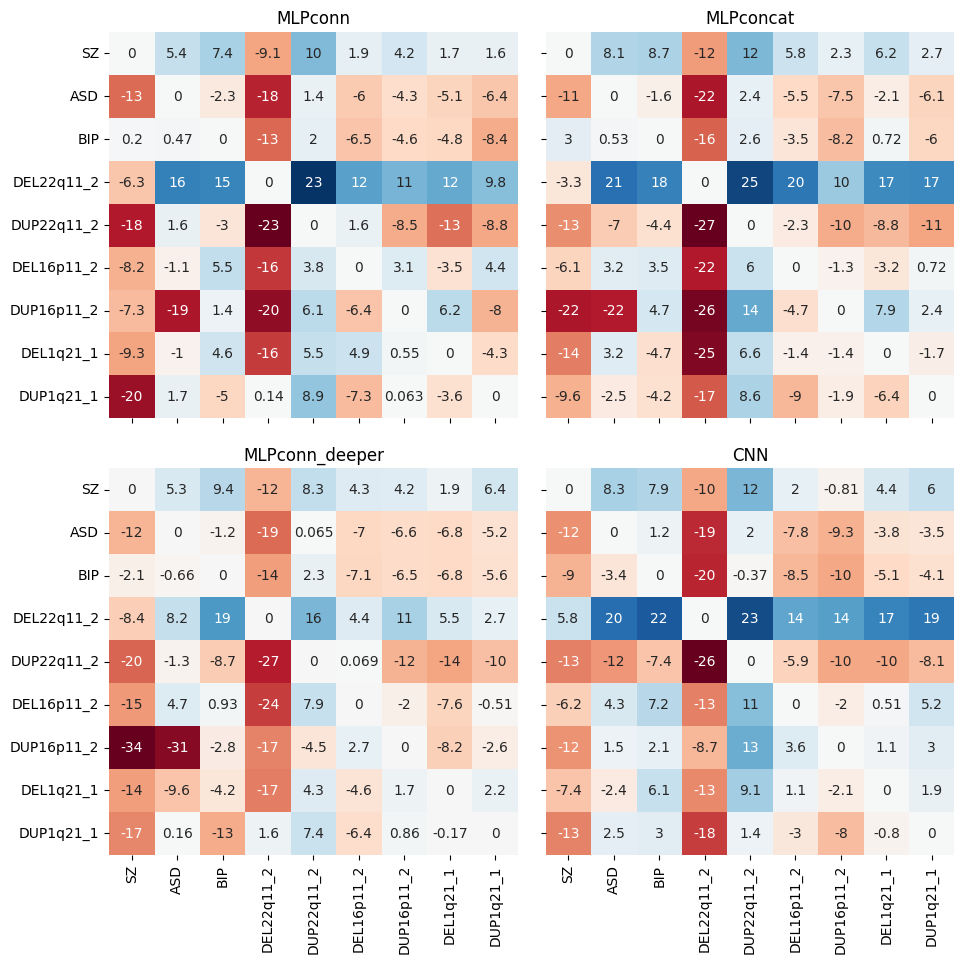

In [34]:
fig,ax = plt.subplots(2,2,figsize=(10,10),sharey=True,sharex=True)
sns.heatmap(mlp_diff,xticklabels=cases,yticklabels=cases,annot=True,cmap='RdBu',cbar=False,ax=ax[0,0],center=0)
sns.heatmap(concat_diff,xticklabels=cases,yticklabels=cases,annot=True,cmap='RdBu',cbar=False,ax=ax[0,1],center=0)
sns.heatmap(deeper_diff,xticklabels=cases,yticklabels=cases,annot=True,cmap='RdBu',cbar=False,ax=ax[1,0],center=0)
sns.heatmap(cnn_diff,xticklabels=cases,yticklabels=cases,annot=True,cmap='RdBu',cbar=False,ax=ax[1,1],center=0)
ax[0,0].set_title('MLPconn')
ax[0,1].set_title('MLPconcat')
ax[1,0].set_title('MLPconn_deeper')
ax[1,1].set_title('CNN')
plt.tight_layout(pad=2)
plt.savefig('./results/neg_transfer/figures/quad_comparison.png',dpi=300)

# Correlate

In [35]:
# MLPconn & MLPconn_deeper
pearsonr(mlp_diff.reshape(-1),deeper_diff.reshape(-1))

PearsonRResult(statistic=0.8499864932253675, pvalue=1.0730283644231324e-23)

In [36]:
# MLPconn & MLPconcat
pearsonr(mlp_diff.reshape(-1),concat_diff.reshape(-1))

PearsonRResult(statistic=0.9027802378822026, pvalue=1.114595345083465e-30)

In [37]:
# MLPconn & CNN
pearsonr(mlp_diff.reshape(-1),cnn_diff.reshape(-1))

PearsonRResult(statistic=0.8140373167354061, pvalue=2.4961097773768707e-20)